# Imports

In [1]:
import time
import numpy as np
import torch
import torchvision
import torch.nn.functional as F

from torch.utils.data import random_split
from torchvision.transforms import transforms
from IPython.display import clear_output
from copy import deepcopy
from matplotlib import pyplot as plt
from torch import Generator
from torch import nn
from torch.utils.data import random_split, Dataset
from tqdm.notebook import tqdm

%matplotlib inline

# Helper functions

## Dataset

In [2]:
class MapDataset(Dataset):
    def __init__(self, dataset, map_fn):
        self.dataset = dataset
        self.map = map_fn
    
    def __getitem__(self, index):
        return self.map(self.dataset[index][0]), self.dataset[index][1]
    
    def __len__(self):
        return len(self.dataset)


def split_dataset(dataset, percentage, random_seed=0):
    dataset_length = len(dataset)
    valid_length = int(np.floor(percentage * dataset_length))
    train_length = dataset_length - valid_length
    train_dataset, valid_dataset = random_split(dataset, [train_length, valid_length],
                                                generator=Generator().manual_seed(random_seed))
    
    return train_dataset, valid_dataset


transf = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

train_dataset = torchvision.datasets.MNIST("./data", train=True, transform=None, download=True)
train, validation = split_dataset(train_dataset, 0.1)

train, validation = MapDataset(train, transf), MapDataset(validation, transf)
train_dataloader = torch.utils.data.DataLoader(train, batch_size=100, shuffle=True, num_workers=2, pin_memory=True,
                                               persistent_workers=True)
valid_dataloader = torch.utils.data.DataLoader(validation, batch_size=1000, shuffle=False, num_workers=2,
                                               pin_memory=True, persistent_workers=True)

test_dataset = torchvision.datasets.MNIST("./data", train=False, transform=transf, download=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1000, shuffle=False, num_workers=2,
                                              pin_memory=True, persistent_workers=True)

## Training

In [3]:
def topk_accuracy(outputs, labels, topk=1):
    outputs = torch.softmax(outputs, dim=1)
    _, preds = outputs.topk(topk, dim=1)
    preds = preds.t()
    correct = preds.eq(labels.view(1, -1).expand_as(preds)).sum()
    return (correct / float(len(outputs))).item()


def run(model, dataloader, criterion, optimizer, device, l1_lmbda):
    train = optimizer is not None
    
    tot_loss = 0.
    outputs = []
    targets = []
    
    model.train(train)
    for data, target in tqdm(dataloader):
        data, target = data.to(device), target.to(device)
        
        with torch.set_grad_enabled(train):
            output = model(data)
            loss = criterion(output, target)
            if l1_lmbda != 0:
                loss += l1_lmbda * sum(torch.linalg.vector_norm(p, 1) for p in model.parameters())
        
        if train:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        tot_loss += loss.item()
        outputs.append(output.detach().float())
        targets.append(target)
    
    outputs = torch.cat(outputs, dim=0)
    targets = torch.cat(targets, dim=0)
    
    accs = {
        'top1': topk_accuracy(outputs, targets, topk=1) * 100,
        'top5': topk_accuracy(outputs, targets, topk=5) * 100
    }
    return {'loss': tot_loss / len(dataloader.dataset), 'accuracy': accs}

## Pruning

In [4]:
def unstructured_magnitude_pruning(model, amount):
    for n, m in model.named_modules():
        if isinstance(m, (nn.Linear, nn.Conv2d)):
            prune.l1_unstructured(m, "weight", amount)

def structured_magnitude_pruning(model, amount):
    layers = [(n, m) for n, m in model.named_modules() if isinstance(m, (nn.Linear, nn.Conv2d))]
    for i, (n, m) in enumerate(layers):
        if i+1 < len(layers):
            prune.ln_structured(m, "weight", amount, 1, 0)


def finalize_pruning(model):
    for n, m in model.named_modules():
        if hasattr(m, "weight_mask"):
            prune.remove(m, "weight")


def get_pruning_statistics(model):
    stats = {}
    
    for n, m in model.named_modules():
        if isinstance(m, (nn.Linear, nn.Conv2d)):
            total_weights = m.weight.numel()
            total_neurons = m.weight.shape[0]
            if isinstance(m, nn.Linear):
                non_zero_weights = torch.count_nonzero(m.weight)
                non_zero_neurons = torch.sum(torch.abs(m.weight), dim=1).count_nonzero()
            elif isinstance(m, nn.Conv2d):
                non_zero_weights = torch.count_nonzero(m.weight)
                non_zero_neurons = torch.sum(torch.abs(m.weight), dim=(1, 2, 3)).count_nonzero()
            
            stats[n] = {"total_weights":     total_weights,
                        "non_zero_weights":  non_zero_weights.item(),
                        "zero_weights":      (total_weights - non_zero_weights).item(),
                        "zero_weights_perc": (100 - (non_zero_weights / total_weights * 100)).item(),
                        "total_neurons":     total_neurons,
                        "non_zero_neurons": non_zero_neurons.item(),
                        "zero_neurons":      (total_neurons - non_zero_neurons).item(),
                        "zero_neurons_perc": (100 - (non_zero_neurons / total_neurons * 100)).item()}

    return stats

## Plots

In [5]:
def plot(data, fnc, xlabel, ylabel, title):
    legend = False
    for x, y, label in data:

        if label != "":
            legend = True

        fnc(x, y, label=label)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
    plt.title(title)
    
    if legend:
        plt.legend()

    plt.show()
    
def plot_layer_sparsity(layer):
    bin_weight = torch.where(layer.weight == 0, torch.zeros_like(layer.weight), torch.ones_like(layer.weight))
    
    plt.pcolormesh(bin_weight, edgecolors='r', linewidth=2, cmap="gray", vmin=0, vmax=1)
    ax = plt.gca()
    ax.set_aspect('equal')
    plt.xlabel("Connections")
    plt.ylabel("Neurons")
    plt.tight_layout()
    plt.show()

# Making deep neural networks efficient with PyTorch

State-of-the-art deep learning techniques rely on over-parametrized models that are hard to deploy. On the contrary, biological neural networks are known to use efficient sparse connectivity. Identifying optimal techniques to compress models by reducing the number of parameters in them is important in order to reduce memory, battery, and hardware consumption without sacrificing accuracy, deploy lightweight models on device, and guarantee privacy with private on-device computation.

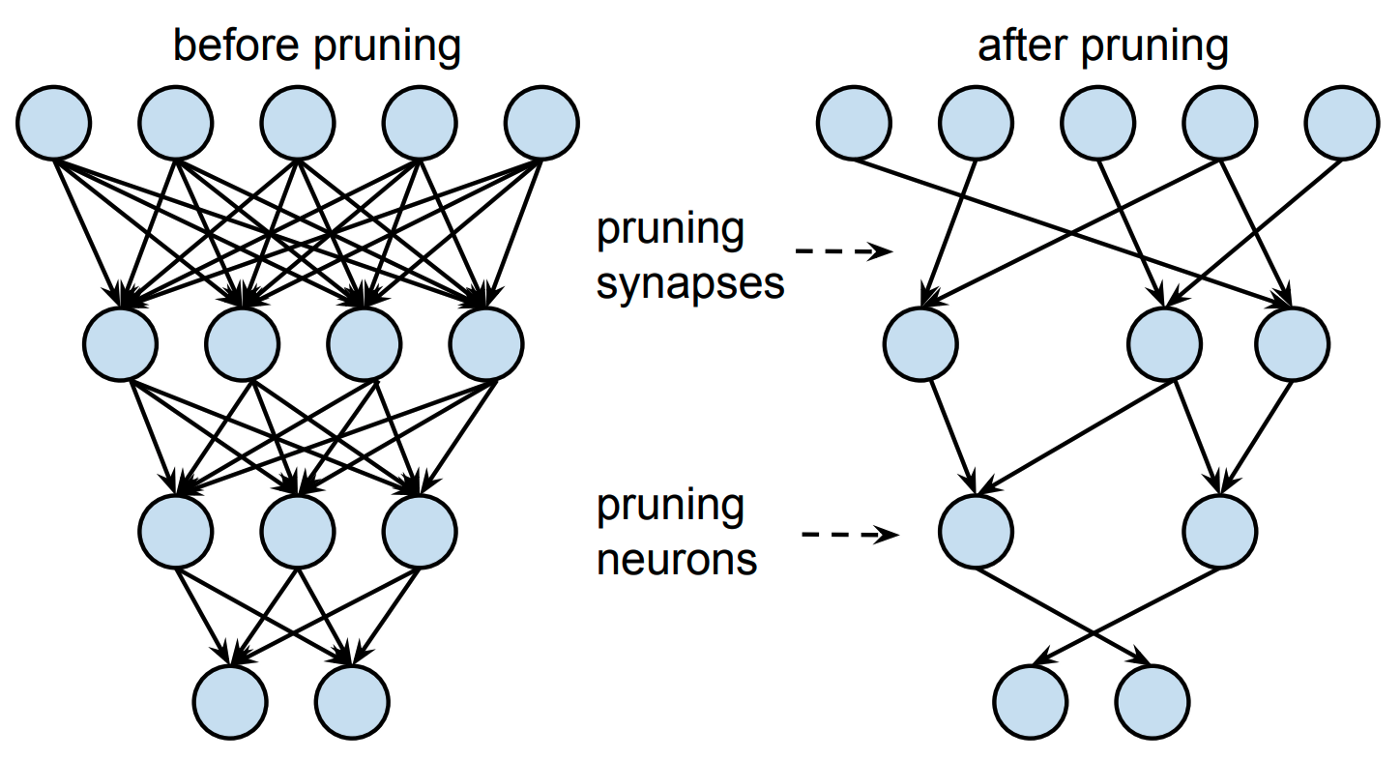

In this notebook we will leverage on the PyTorch's `nn.utils.prune` package to show the difference between unstructured and structured sparsification in a one-shot pruning procedure.

We will:

1. Cover the basics of `torch.nn.utils.prune`.
2. Apply unstructured and structured pruning procedures (with and without fine-tuning).
3. Introduce `simplify` to exploit the introduced structured sparsity.

## Introduction - PyTorch pruning

As a first example, we will prune a `Linear` module. Note that all considerations also apply to other module type, e.g. `Conv2d`.

Let's define a simple `Linear` module with 10 `in_features` and 2 `out_features`.

In [6]:
module = nn.Linear(10, 2)
print(module)

Linear(in_features=10, out_features=2, bias=True)


We can inspect the module and see that it contains two parameters: `weight` and `bias`. And no buffers.

In [7]:
for n, p in module.named_parameters():
    print(f"{n}\n{p}\n{p.shape}\n")

weight
Parameter containing:
tensor([[-0.2160, -0.1673, -0.0510, -0.0230,  0.0017, -0.2426,  0.1072, -0.2146,
         -0.0777,  0.0804],
        [-0.3134, -0.2669, -0.2226,  0.1492, -0.1477, -0.1901,  0.1898, -0.3055,
         -0.1717, -0.2224]], requires_grad=True)
torch.Size([2, 10])

bias
Parameter containing:
tensor([-0.2202, -0.0843], requires_grad=True)
torch.Size([2])



In [8]:
print(list(module.named_buffers()))

[]


Now that we defined our module, let's see how can we prune it using the `nn.utils.prune` package. In this example we will perform a magnitude-based pruning, removing 30% of the module parameters.

PyTorch provides different, already implemented, functions. In this case, we will employ the `random_unstructured` function.

In [9]:
from torch.nn.utils import prune

prune.random_unstructured(module, name="weight", amount=0.3)

Linear(in_features=10, out_features=2, bias=True)

The pruning procedures preserve the original parameter values, removing the target parameter and replacing it appending `"_orig"` to the initial parameter's `name`. In this case, `weight_orig` stores the unpruned version of the tensor. The bias was not pruned, so it will remain intact.

In [10]:
for n, p in module.named_parameters():
    print(f"{n}\n{p}\n{p.shape}\n")

bias
Parameter containing:
tensor([-0.2202, -0.0843], requires_grad=True)
torch.Size([2])

weight_orig
Parameter containing:
tensor([[-0.2160, -0.1673, -0.0510, -0.0230,  0.0017, -0.2426,  0.1072, -0.2146,
         -0.0777,  0.0804],
        [-0.3134, -0.2669, -0.2226,  0.1492, -0.1477, -0.1901,  0.1898, -0.3055,
         -0.1717, -0.2224]], requires_grad=True)
torch.Size([2, 10])



The procedure generates a pruning mask (a binary tensor) which is saved as a buffer in the module.

The name of the buffer is defined by appending `"_mask"` to the initial parameter's `name`.

In [11]:
for n, p in module.named_buffers():
    print(f"{n}\n{p}\n{p.shape}\n")

weight_mask
tensor([[1., 0., 1., 0., 0., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 0., 0., 1., 1., 0.]])
torch.Size([2, 10])



For the forward pass to work without modification, the `weight` attribute needs to exist.

For this reason, during any forward pass, the pruned `weight` is defined by combining the mask and the corresponding unpruned parameter. This is done using a `forward_pre_hook`. This also means that the pruning is not lost due to the update of the weight.

Note that `weight` is no longer a parameter but a simple attribute of the module.

In [12]:
print(module.weight)

tensor([[-0.2160, -0.0000, -0.0510, -0.0000,  0.0000, -0.2426,  0.1072, -0.2146,
         -0.0777,  0.0804],
        [-0.3134, -0.2669, -0.2226,  0.1492, -0.1477, -0.0000,  0.0000, -0.3055,
         -0.1717, -0.0000]], grad_fn=<MulBackward0>)


To make the pruning permanent, remove the re-parametrization in terms of `weight_orig` and `weight_mask`, and remove the `forward_pre_hook`, we can use the `remove` functionality from `nn.utils.prune`.

Note that this doesn’t undo the pruning, as if it never happened. It simply makes it permanent, instead, by reassigning the parameter `weight` to the model parameters, in its pruned version.

bias
Parameter containing:
tensor([-0.2202, -0.0843], requires_grad=True)
torch.Size([2])

weight
Parameter containing:
tensor([[-0.2160, -0.0000, -0.0510, -0.0000,  0.0000, -0.2426,  0.1072, -0.2146,
         -0.0777,  0.0804],
        [-0.3134, -0.2669, -0.2226,  0.1492, -0.1477, -0.0000,  0.0000, -0.3055,
         -0.1717, -0.0000]], requires_grad=True)
torch.Size([2, 10])

Visual representation


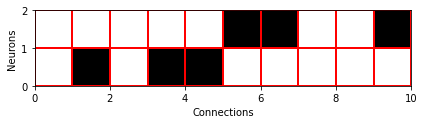

In [13]:
prune.remove(module, 'weight')

for n, p in module.named_parameters():
    print(f"{n}\n{p}\n{p.shape}\n")

print("Visual representation")
plot_layer_sparsity(module)

As with most of PyTorch functionalities, we are not limited by the provided functions but we can implement custom procedures by subclassing the `BasePruningMethod` class, implementing the `__init__` and `compute_mask()` functions

### Unstructured vs structured sparsification

Unstructured


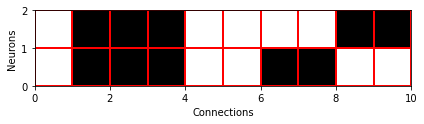

Structured


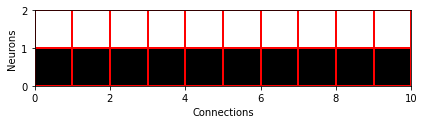

In [14]:
unstructured = nn.Linear(10, 2)
structured = nn.Linear(10, 2)

prune.random_unstructured(unstructured, name="weight", amount=0.5)
prune.random_structured(structured, name="weight", amount=0.5, dim=0)

print("Unstructured")
plot_layer_sparsity(unstructured)
print("Structured")
plot_layer_sparsity(structured)

## Neural network pruning

Now that we have seen the functionalities of `nn.utils.prune` on a single module, let's use it to prune an entire neural network model.

for simplicity's sake, in this tutorial, we will use the [LeNet-5 Caffe architecture](https://caffe.berkeleyvision.org/gathered/examples/mnist.html) and the [MNIST dataset](http://yann.lecun.com/exdb/mnist/).

Following a simple one-shot strategy, we will:

1. Train a baseline, dense, model.
2. Prune the trained models and compare the sparse models accuracy with the baseline obtained in the first step.
3. Fine-tune the pruned models and evaluate the (eventual) recover of performance lost during due to the pruning step.



### Define the network architecture

As mentioned, for this example we will use the Caffe version of the LeNet-5 architecture.

This model is composed of four layers: two `Conv2d` of 20 and 50 channels respectively, and two `Linear` of 500 and 10 neurons.

In [15]:
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=20, kernel_size=5, stride=1, bias=True)
        self.conv2 = nn.Conv2d(in_channels=20, out_channels=50, kernel_size=5, stride=1, bias=True)
        self.fc1 = nn.Linear(800, 500, bias=True)
        self.fc2 = nn.Linear(500, 10, bias=True)
        self.relu = nn.ReLU()
    
    def forward(self, img):
        output = self.relu(self.conv1(img))
        output = F.max_pool2d(output, 2)
        output = self.relu(self.conv2(output))
        output = F.max_pool2d(output, 2)
        output = output.view(img.size(0), -1)
        output = self.relu(self.fc1(output))
        output = self.fc2(output)
        
        return output

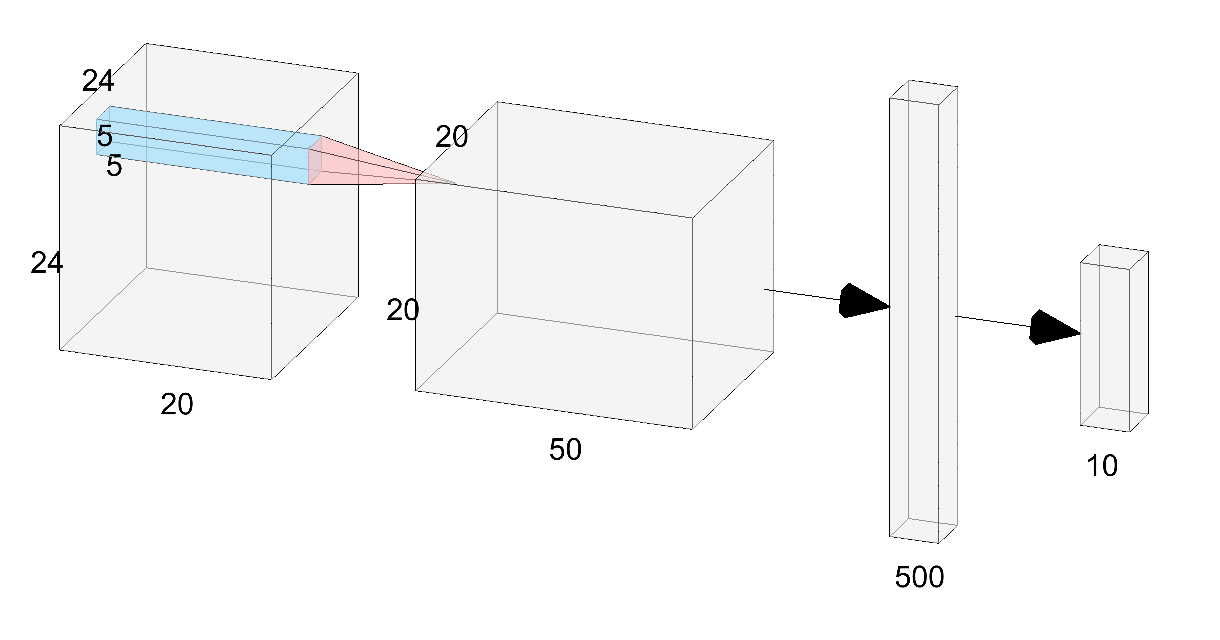

### Training the networks

The trainin procedure is standard: we will train the model using `SGD` with a learning rate of 0.1 and a `cross_entropy` loss.

In [16]:
epochs = 5
learning_rate = 0.1

device = "cuda" if torch.cuda.is_available() else "cpu"
model = LeNet5().to(device)

criterion = F.cross_entropy
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

Let's start with training the baseline model. During training we will keep track of the best weight configuration (highest accuracy), which will be used in the following phases.

The network should be able to achieve an accuracy of 99.2% on the test set in around 10 epochs.

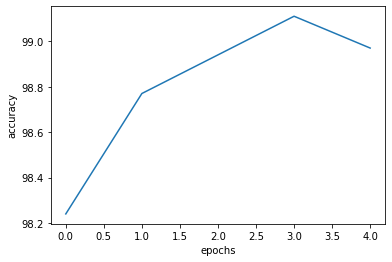

In [17]:
test_acc = []

dense_trained_model_test_acc = 0

for epoch in range(epochs):
    train = run(model, train_dataloader, criterion, optimizer, device, 0)
    test = run(model, test_dataloader, criterion, None, device, 0)
    test_acc.append(test["accuracy"]["top1"])

    if test["accuracy"]["top1"] > dense_trained_model_test_acc:
        dense_trained_model_test_acc = test["accuracy"]["top1"]
        dense_trained_model = deepcopy(model.state_dict())

    clear_output(wait=True)
    plot([(range(0, epoch+1), test_acc, "")],
         plt.plot, "epochs", "accuracy", "")


### Unstructured pruning without fine-tuning

Now that we obtained our trained network, we can move on to the pruning stage. Here we will evaluate the performance of the model for different percentages of pruned parameters.

To prune the network we will use the magnitude-based approach implemented in the `l1_unstructured` function.

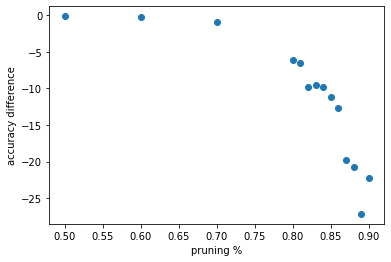

In [18]:
test_acc = []
amounts = [0.5, 0.6, 0.7, 0.8, 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89, 0.9,]

for i, amount in enumerate(amounts):
    model.load_state_dict(dense_trained_model)

    unstructured_magnitude_pruning(model, amount)
    finalize_pruning(model)
    
    test = run(model, test_dataloader, criterion, None, device, 0)
    test_acc.append(test["accuracy"]["top1"] - dense_trained_model_test_acc)

    clear_output(wait=True)
    plot([(amounts[:i+1], test_acc, "")],
         plt.scatter, "pruning %", "accuracy difference", "")

We can see that the performance degrades as we remove paramameters from the network. The more parameters we remove the more the accuracy drops.

### Unstructured pruning with fine-tuning

Let's introduce a fine-tuning step after the pruning stage. Thanks to this new step, we can recover some of the accuracy lost when pruning the parameters.

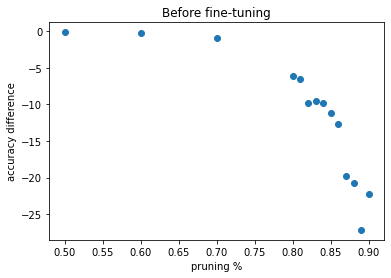

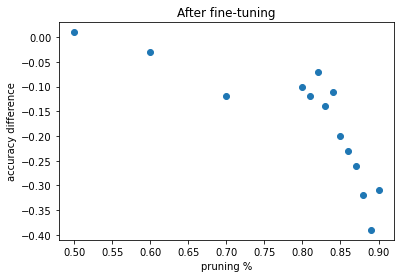

In [19]:
test_acc_ft = []
fine_tune_epochs = 1
fine_tune_lr = 0.1

optimizer = torch.optim.SGD(model.parameters(), lr=fine_tune_lr)
for i, amount in enumerate(amounts):
    model.load_state_dict(dense_trained_model)

    unstructured_magnitude_pruning(model, amount)

    for epoch in range(fine_tune_epochs):
        run(model, train_dataloader, criterion, optimizer, device, 0)

    finalize_pruning(model)
    
    test = run(model, test_dataloader, criterion, None, device, 0)
    test_acc_ft.append(test["accuracy"]["top1"] - dense_trained_model_test_acc)

    clear_output(wait=True)
    plot([(amounts[:i+1], test_acc_ft, "")],
         plt.scatter, "pruning %", "accuracy difference", "After fine-tuning")

clear_output(wait=True) 
plot([(amounts, test_acc, "")],
        plt.scatter, "pruning %", "accuracy difference", "Before fine-tuning")
plot([(amounts, test_acc_ft, "")],
        plt.scatter, "pruning %", "accuracy difference", "After fine-tuning")

Comparing the accuracy lost before and after the fine-tuning step, we can see that this step is quite beneficial: the drop in accuracy after fine-tuning is way less severe.

### Structured pruning (with fine-tuning)

Up untill now, we focused on unstructured pruning procedure, in which we remove parameters independently.

Now we will introduce, in our network, a structured sparsification. To this end, we will use the provided `ln_unstructured` function, with the L1-norm along the 0-th dimension (the one representing the neurons of the module).

Structured pruning poses a stronger constraint on the network and the loss in performance is usually grater, even if the amount of pruned weights is roughly the same (pruning 50% of the neurons prunes around 50% of the parameters).

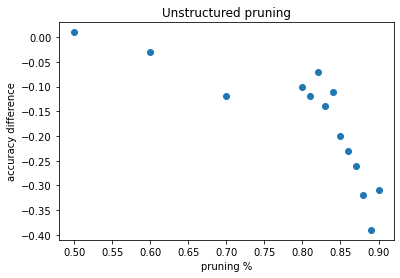

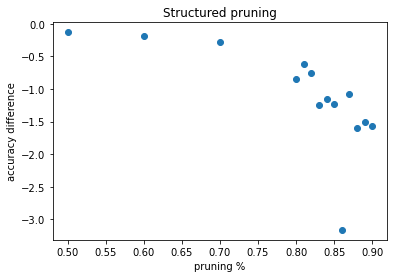

In [20]:
test_acc_ft_st = []

fine_tune_epochs = 1
fine_tune_lr = 0.1

model = LeNet5().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=fine_tune_lr)

for i, amount in enumerate(amounts):
    model.load_state_dict(dense_trained_model)

    structured_magnitude_pruning(model, amount)

    for epoch in range(fine_tune_epochs):
        run(model, train_dataloader, criterion, optimizer, device, 0)

    finalize_pruning(model)
    
    test = run(model, test_dataloader, criterion, None, device, 0)
    test_acc_ft_st.append(test["accuracy"]["top1"] - dense_trained_model_test_acc)

    clear_output(wait=True)
    plot([(amounts[:i+1], test_acc_ft_st, "")],
         plt.scatter, "pruning %", "accuracy difference", "Structured pruning")


clear_output(wait=True)
plot([(amounts, test_acc_ft, "")],
        plt.scatter, "pruning %", "accuracy difference", "Unstructured pruning")
plot([(amounts, test_acc_ft_st, "")],
        plt.scatter, "pruning %", "accuracy difference", "Structured pruning")

### Exploiting structured sparsity

If structured sparsity is harder to achive, why are we interested in it?

The strenght of structured sparsity lays in the ability to actually shrink the resulting network, removing enitre rows (or columns) from the matrices that represent the layers. This allows us to produce smaller and faster models without the need for ad hoc software or hardware able to run sparse tensors.

[Simplify](https://github.com/EIDOSlab/simplify) is an open source PyTorch-compatible library. It allows us to exploit the introduced structured sparsity by removing zeroed neurons from the network architecture.

It can be installed via pip:

In [33]:
!pip3 install torch-simplify

#### Simplification visualized

Dense module


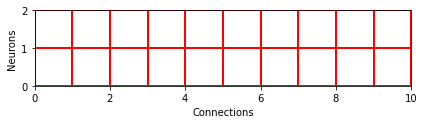

Unstructured sparity


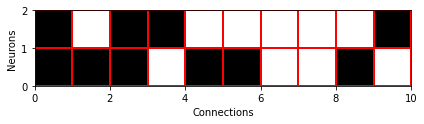

Structured sparity


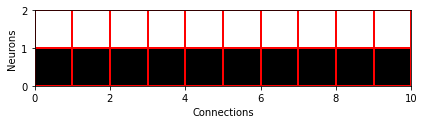

Simplified module


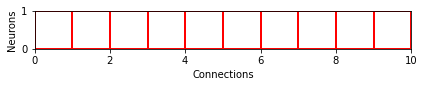

In [35]:
import simplify

module = nn.Linear(10, 2)
data = torch.randn(1, 10)

print("Dense module")
plot_layer_sparsity(module)

unstructured = deepcopy(module)
structured = deepcopy(module)

print("Unstructured sparity")
prune.l1_unstructured(unstructured, "weight", 0.5)
prune.remove(unstructured, "weight")
plot_layer_sparsity(unstructured)

print("Structured sparity")
prune.ln_structured(structured, "weight", 0.5, 1, 0)
prune.remove(structured, "weight")    
plot_layer_sparsity(structured)

print("Simplified module")
simplified_module = simplify.simplify(structured, data, [], False, [])
plot_layer_sparsity(simplified_module)

#### Simplification applications

Let's see how we can use the structured sparsity of a `nn.Conv2d` module in which we prune 50% of the parameters.

In this example we will compare the inference speed of the dense module, the pruned module (both unstructured and structured), and the simplified module.

In [38]:
module = nn.Conv2d(20, 50, 5)
data = torch.randn(1, 20, 24, 24)

unstructured = deepcopy(module)
structured = deepcopy(module)

prune.l1_unstructured(unstructured, "weight", 0.5)
prune.remove(unstructured, "weight")

prune.ln_structured(structured, "weight", 0.5, 1, 0)
prune.remove(structured, "weight")

dense_times = []
for i in tqdm(range(10000)):
    start = time.perf_counter_ns()
    module(data)
    dense_times.append((time.perf_counter_ns() - start) / 1e+6)

unstructured_times = []
for i in tqdm(range(10000)):
    start = time.perf_counter_ns()
    unstructured(data)
    unstructured_times.append((time.perf_counter_ns() - start) / 1e+6)

structured_times = []
for i in tqdm(range(10000)):
    start = time.perf_counter_ns()
    structured(data)
    structured_times.append((time.perf_counter_ns() - start) / 1e+6)

simplified_module = simplify.simplify(structured, data, [], False, [])

simplified_times = []
for i in tqdm(range(10000)):
    start = time.perf_counter_ns()
    simplified_module(data)
    simplified_times.append((time.perf_counter_ns() - start) / 1e+6)
    
print(f"Dense module inference time {np.mean(dense_times[1:])}ms pm {np.std(dense_times[1:])}")
print(f"Unstructured module inference time {np.mean(unstructured_times[1:])}ms pm {np.std(unstructured_times[1:])}")
print(f"Structured module inference time {np.mean(structured_times[1:])}ms pm {np.std(structured_times[1:])}")
print(f"Simplified module inference time {np.mean(simplified_times[1:])}ms pm {np.std(simplified_times[1:])}")


100%|██████████| 10000/10000 [00:02<00:00, 4543.91it/s]

Dense module inference time 0.2815171503150315ms pm 0.2948950063369211
Unstructured module inference time 0.2689001304130413ms pm 0.29674863881351055
Structured module inference time 0.2981526625662566ms pm 0.36892047745011985
Simplified module inference time 0.21193301110111012ms pm 0.18331753520798727


What about and entire neural network? Again, we will use the LeNet-5 model.

In [40]:
data = torch.randn(1, 1, 28, 28)

model = LeNet5()
structured_magnitude_pruning(model, 0.5)
finalize_pruning(model)

simplified_model = simplify.simplify(deepcopy(model), torch.randn(1, 1, 28, 28))

print(model)
print(simplified_model)

pruned_times = []
for i in tqdm(range(10000)):
    start = time.perf_counter_ns()
    model(data)
    pruned_times.append((time.perf_counter_ns() - start) / 1e+6)

simplified_times = []
for i in tqdm(range(10000)):
    start = time.perf_counter_ns()
    simplified_model(data)
    simplified_times.append((time.perf_counter_ns() - start) / 1e+6)

print(f"Pruned model inference time {np.mean(pruned_times[1:])}ms pm {np.std(pruned_times[1:])}")
print(f"Simplified model inference time {np.mean(simplified_times[1:])}ms pm {np.std(simplified_times[1:])}")

LeNet5(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=800, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
  (relu): ReLU()
)
LeNet5(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 25, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=250, bias=True)
  (fc2): Linear(in_features=250, out_features=10, bias=True)
  (relu): ReLU()
)


100%|██████████| 10000/10000 [00:04<00:00, 2020.66it/s]

Pruned model inference time 0.6143078355835584ms pm 0.4806002021288764
Simplified model inference time 0.4852566887688769ms pm 0.30941090605576327
